# Frequency domain based image steganography

This project hides an image inside another one using a frequency domain based method, the Fourier Transform, which transforms the input images into a frequency domain and merge them, creating an output image. This output image will appear to be just the regular input image, but we can recover the information we put in before by decoding, using a similar method.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio

Would be nice to explain this variables and why this values were choosen.

In [2]:
sector_size = 3 # size of the sector used to embed the secret message
idx = 1 # center of the sector

Here we have some helper functions used to pre-process the image before encoding and post-process to save the output images.

In [3]:
# Convert from RGB or RGBA to HSV
def convertHSV(img):
    return matplotlib.colors.rgb_to_hsv(img[:,:,:3].astype(np.float64))

# Convert from HSV to RGB
def convertRGB(img):
    return matplotlib.colors.hsv_to_rgb(img.astype(np.float64))

# Normalize image
def normalize(img):
    imgMin = np.min(img)
    imgMax = np.max(img)
    return (img-imgMin)/(imgMax-imgMin)

# Get V channel of HSV image with values [0, 1]
def floatV(img):
    return img[:,:,2].astype(np.float64)/255

# Execute modulo operation in a image
def modulo(img, value):
    return (img.astype(np.int64)+value) % value

The functions below are responsible for applying the Fast Fourier Transform and the Inverse Fast Fourier Transform, necessary in the encoding and decoding algorithm

In [4]:
# Apply FFT and shift
def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return np.fft.fftshift(imgFFT)

# Apply shift and IFFT
def applyIFFT(img):
    imgShift = np.fft.ifftshift(img)
    imgIFFT = np.fft.ifft2(imgShift)
    return imgIFFT

## Encode function

We apply FFT on both images, then we divide the base image into sectors of sector_size x sector_size, defined earlier. On the center of each sector (given by idx), we embed each secret message's frequency value.

Describe why encoding is not possible here.

In [5]:
"""
This function encode a secret image inside a base image,
returning a modified image using the Fast Fourier method.
---
Parameters:
    base -    base image to receive secret message
    secret -  message to be hidden in base image
"""
def encode(base, secret):
    imgBase = applyFFT(np.copy(base))
    height, width = imgBase.shape
    
    imgSecret = applyFFT(secret)
    imgSecretFlat = imgSecret.flatten()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
        return None, False
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                ind += 1
            else: break

    return applyIFFT(imgBase),True

In [6]:
"""
This function returns the encoded final image 
and the key to decode the image.
---
Parameters:
    img - base image
    secret - secret image
"""
def hideSecret(img,secret):
    # converting RGB images to HSV and extracting V (value attribute)
    imgHSV = convertHSV(img)
    imgV = floatV(imgHSV)
    secretV = floatV(convertHSV(secret))

    # embedding the secret message
    encodedImg, success = encode(imgV, secretV)
    
    if not success: return
    
    # get real part
    encodedImgV = encodedImg.real

    # replacing the V attribute (updated in encode) in base image
    encodedImg = imgHSV
    encodedImg[:,:,2] = encodedImgV.astype(np.float64)*255

    # converting the image back to RGB and saving the encoded image
    finalImg = np.copy(img)
    finalImg[:,:,:3] = convertRGB(encodedImg)
    
    # create a decode key from the noise generated (second approach)
    finalImgV = floatV(convertHSV(finalImg))
    noisySecret = decode(finalImgV, secretV.shape).real

    key = modulo((noisySecret*255).astype(np.int32)-(secretV*255).astype(np.int32), 256).astype(np.uint8)
    
    return finalImg, key

## Decode function

Similar to the embedding function, we recover the secret message from the base image that was previously encoded.

In [7]:
"""
This function decode an image, returning the secret 
message embedded using the Fast Fourier method.
---
Parameters:
    img - image with embedded secret
    key - shape of the secret image
"""
def decode(img,key):
    imgBase = applyFFT(img)
    height, width = imgBase.shape
    
    secret_h, secret_w = key
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return applyIFFT(secret)   

### Decoding problem

Write some stuff about the decoding problem with saved images, the complex values...

In [8]:
# retrieving the secret message thats embedded on the encoded image using the first approach
"""secret = decode(encodedImageV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)
imageio.imsave('./images/output_qrcode.png', finalSecret)

plt.figure(figsize=(15,5))

ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")"""

'secret = decode(encodedImageV, imgSecretV.shape).real\nfinalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)\nimageio.imsave(\'./images/output_qrcode.png\', finalSecret)\n\nplt.figure(figsize=(15,5))\n\nax = plt.subplot(121)\nax.title.set_text(\'Decoded Message before noise removal\')\nplt.imshow(secret, cmap="gray")\n\nax = plt.subplot(122)\nax.title.set_text(\'Decoded Message after noise removal\')\nplt.imshow(finalSecret, cmap="gray")'

In [9]:
"""# retrieving the secret message thats embedded on the encoded image using the first approach with saved image
img = imageio.imread('./images/output_windows_qrcode.png')
imgV = floatV(convertHSV(img))

noisySecret = decode(imgV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(noisySecret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")"""

'# retrieving the secret message thats embedded on the encoded image using the first approach with saved image\nimg = imageio.imread(\'./images/output_windows_qrcode.png\')\nimgV = floatV(convertHSV(img))\n\nnoisySecret = decode(imgV, imgSecretV.shape).real\nfinalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)\n\nplt.figure(figsize=(15,5))\nax = plt.subplot(121)\nax.title.set_text(\'Decoded Message before noise removal\')\nplt.imshow(noisySecret, cmap="gray")\n\nax = plt.subplot(122)\nax.title.set_text(\'Decoded Message after noise removal\')\nplt.imshow(finalSecret, cmap="gray")'

In [10]:
"""
This function returns the secret image 
hidden in another image.
---
Parameters:
    img - encoded image
    key - decodification key
"""
def revealSecret(img,key):
    # getting V attribute of HSV converted img
    imgV = floatV(convertHSV(img))
    # getting the secret image
    secret = decode(imgV, key.shape)
    # returning key without noise
    key = (modulo((secret.real*255).astype(np.int32)-key, 256)).astype(np.uint8)
    return key

##  Test Cases

Input images sources:
   * Windows XP classic wallpaper - https://wallpapercave.com/w/wp2754860
   * Generated QR code - https://www.the-qrcode-generator.com/ (*Read the code to see where it takes you :p*)
   * Flock of birds landscape - https://www.pexels.com/photo/flock-of-birds-917494/
   * Google Chrome T-Rex - https://www.pngwing.com/pt/free-png-xzvzd
   

---

## Windows XP classic wallpaper + random QR code

### Encoding image

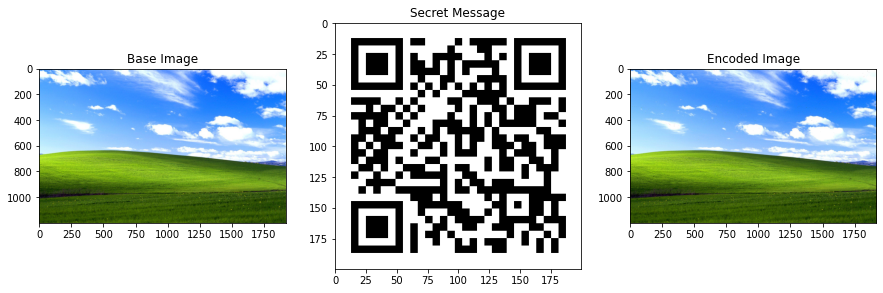

In [11]:
# reading the base image
img = plt.imread('./images/input_windows.jpg')
# reading the secret message
secret = plt.imread('./images/input_qrcode.png')

# encoding secret image in base image
finalImg, key = hideSecret(img,secret)

# saving output image in file
imageio.imsave('./images/output_windows_qrcode.png', finalImg)
# saving key to decode in file
imageio.imsave('./images/output_qrcode_key.png', key)

# plotting images
plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)
ax1.title.set_text('Base Image')
plt.imshow(img)

ax2 = plt.subplot(132)
ax2.title.set_text('Secret Message')
plt.imshow(secret)

ax3 = plt.subplot(133)
ax3.title.set_text('Encoded Image')
plt.imshow(finalImg)

### Decoding image

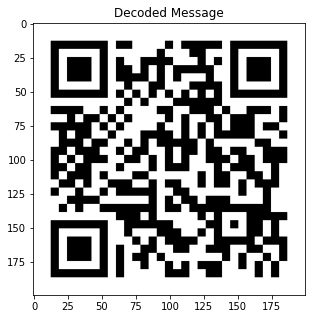

In [12]:
# reading generated images
img = imageio.imread('./images/output_windows_qrcode.png')
key = imageio.imread('./images/output_qrcode_key.png')

# decoding image
secret = revealSecret(img,key)

plt.figure(figsize=(15,5))

ax = plt.subplot(111)
ax.title.set_text('Decoded Message')
plt.imshow(secret, cmap="gray")

---

## Flock of birds landscape + Google Chrome T-Rex

### Encoding image

Using a base image with size approximately 5 times bigger than secret image.

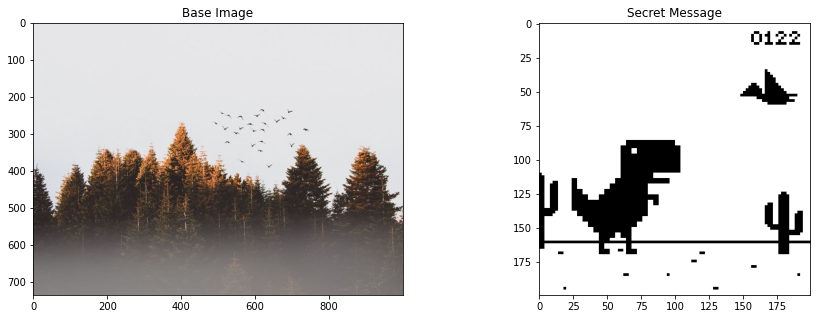

In [13]:
# reading the base image
img = plt.imread('./images/input_trees.jpg')
# reading the secret message
secret = plt.imread('./images/input_trex.png')

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.title.set_text('Base Image')
plt.imshow(img)

ax2 = plt.subplot(122)
ax2.title.set_text('Secret Message')
plt.imshow(secret)

In [14]:
sector_size = 5
# trying to embedd the secret message
hideSecret(img,secret)

Encoding not possible


With a sector size of 5, is not possible to encode image, because ....

Using a bigger image (approximate size of 3300x2500px) to check how sector size interferes in image degradation.

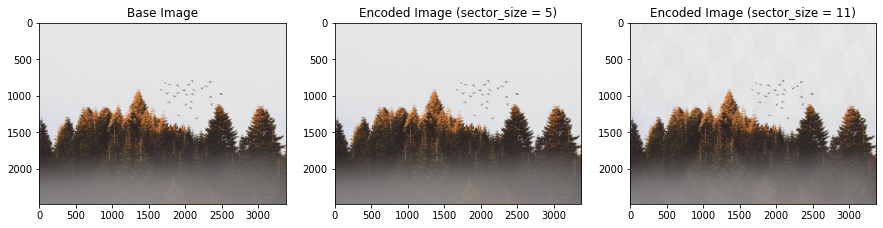

In [15]:
# reading the base image
img = plt.imread('./images/input_trees_big.jpg')

# testing with maximum sector size for this image
sector_size = 11
img_11, key_11 = hideSecret(img,secret)
imageio.imsave('./images/output_birds_trex_11.png', img_11)

# testing with previous sector size
sector_size = 5
img_5, key_5 = hideSecret(img,secret)
imageio.imsave('./images/output_birds_trex_5.png', img_5)
imageio.imsave('./images/output_trex_key_5.png', key_5)

# plotting images
plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)
ax1.title.set_text('Base Image')
plt.imshow(img)

ax2 = plt.subplot(133)
ax2.title.set_text('Encoded Image (sector_size = 11)')
plt.imshow(img_11)

ax3 = plt.subplot(132)
ax3.title.set_text('Encoded Image (sector_size = 5)')
plt.imshow(img_5)

### Decoding image

Trying to get the hidden image in the final image of the previous case with the best visual result, the one encoded with sector size 5.

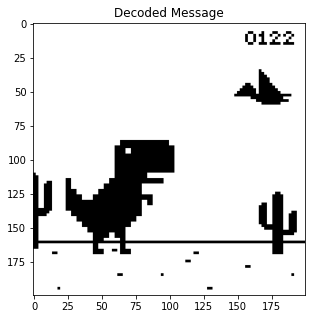

In [16]:
# retrieving the secret message thats embedded on the encoded image using the second approach
img = imageio.imread('./images/output_birds_trex_5.png')
key = imageio.imread('./images/output_trex_key_5.png')

secret = revealSecret(img,key)

plt.figure(figsize=(15,5))

ax = plt.subplot(111)
ax.title.set_text('Decoded Message')
plt.imshow(secret, cmap="gray")